# Quantum Teleportation

In [21]:
import qiskit
from qiskit import QuantumCircuit,  QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, execute,  transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex

### Single Qubit Teleportation

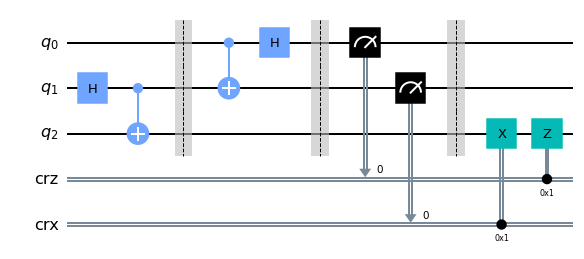

In [12]:
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.measure([qr[0],qr[1]],[crz[0],crx[0]])

qc.barrier()
qc.x(2).c_if(crx, 1) # Apply gates if the registers 
qc.z(2).c_if(crz, 1) # are in the state '1'

qc.draw('mpl')

### Multi-Qubit Teleportation

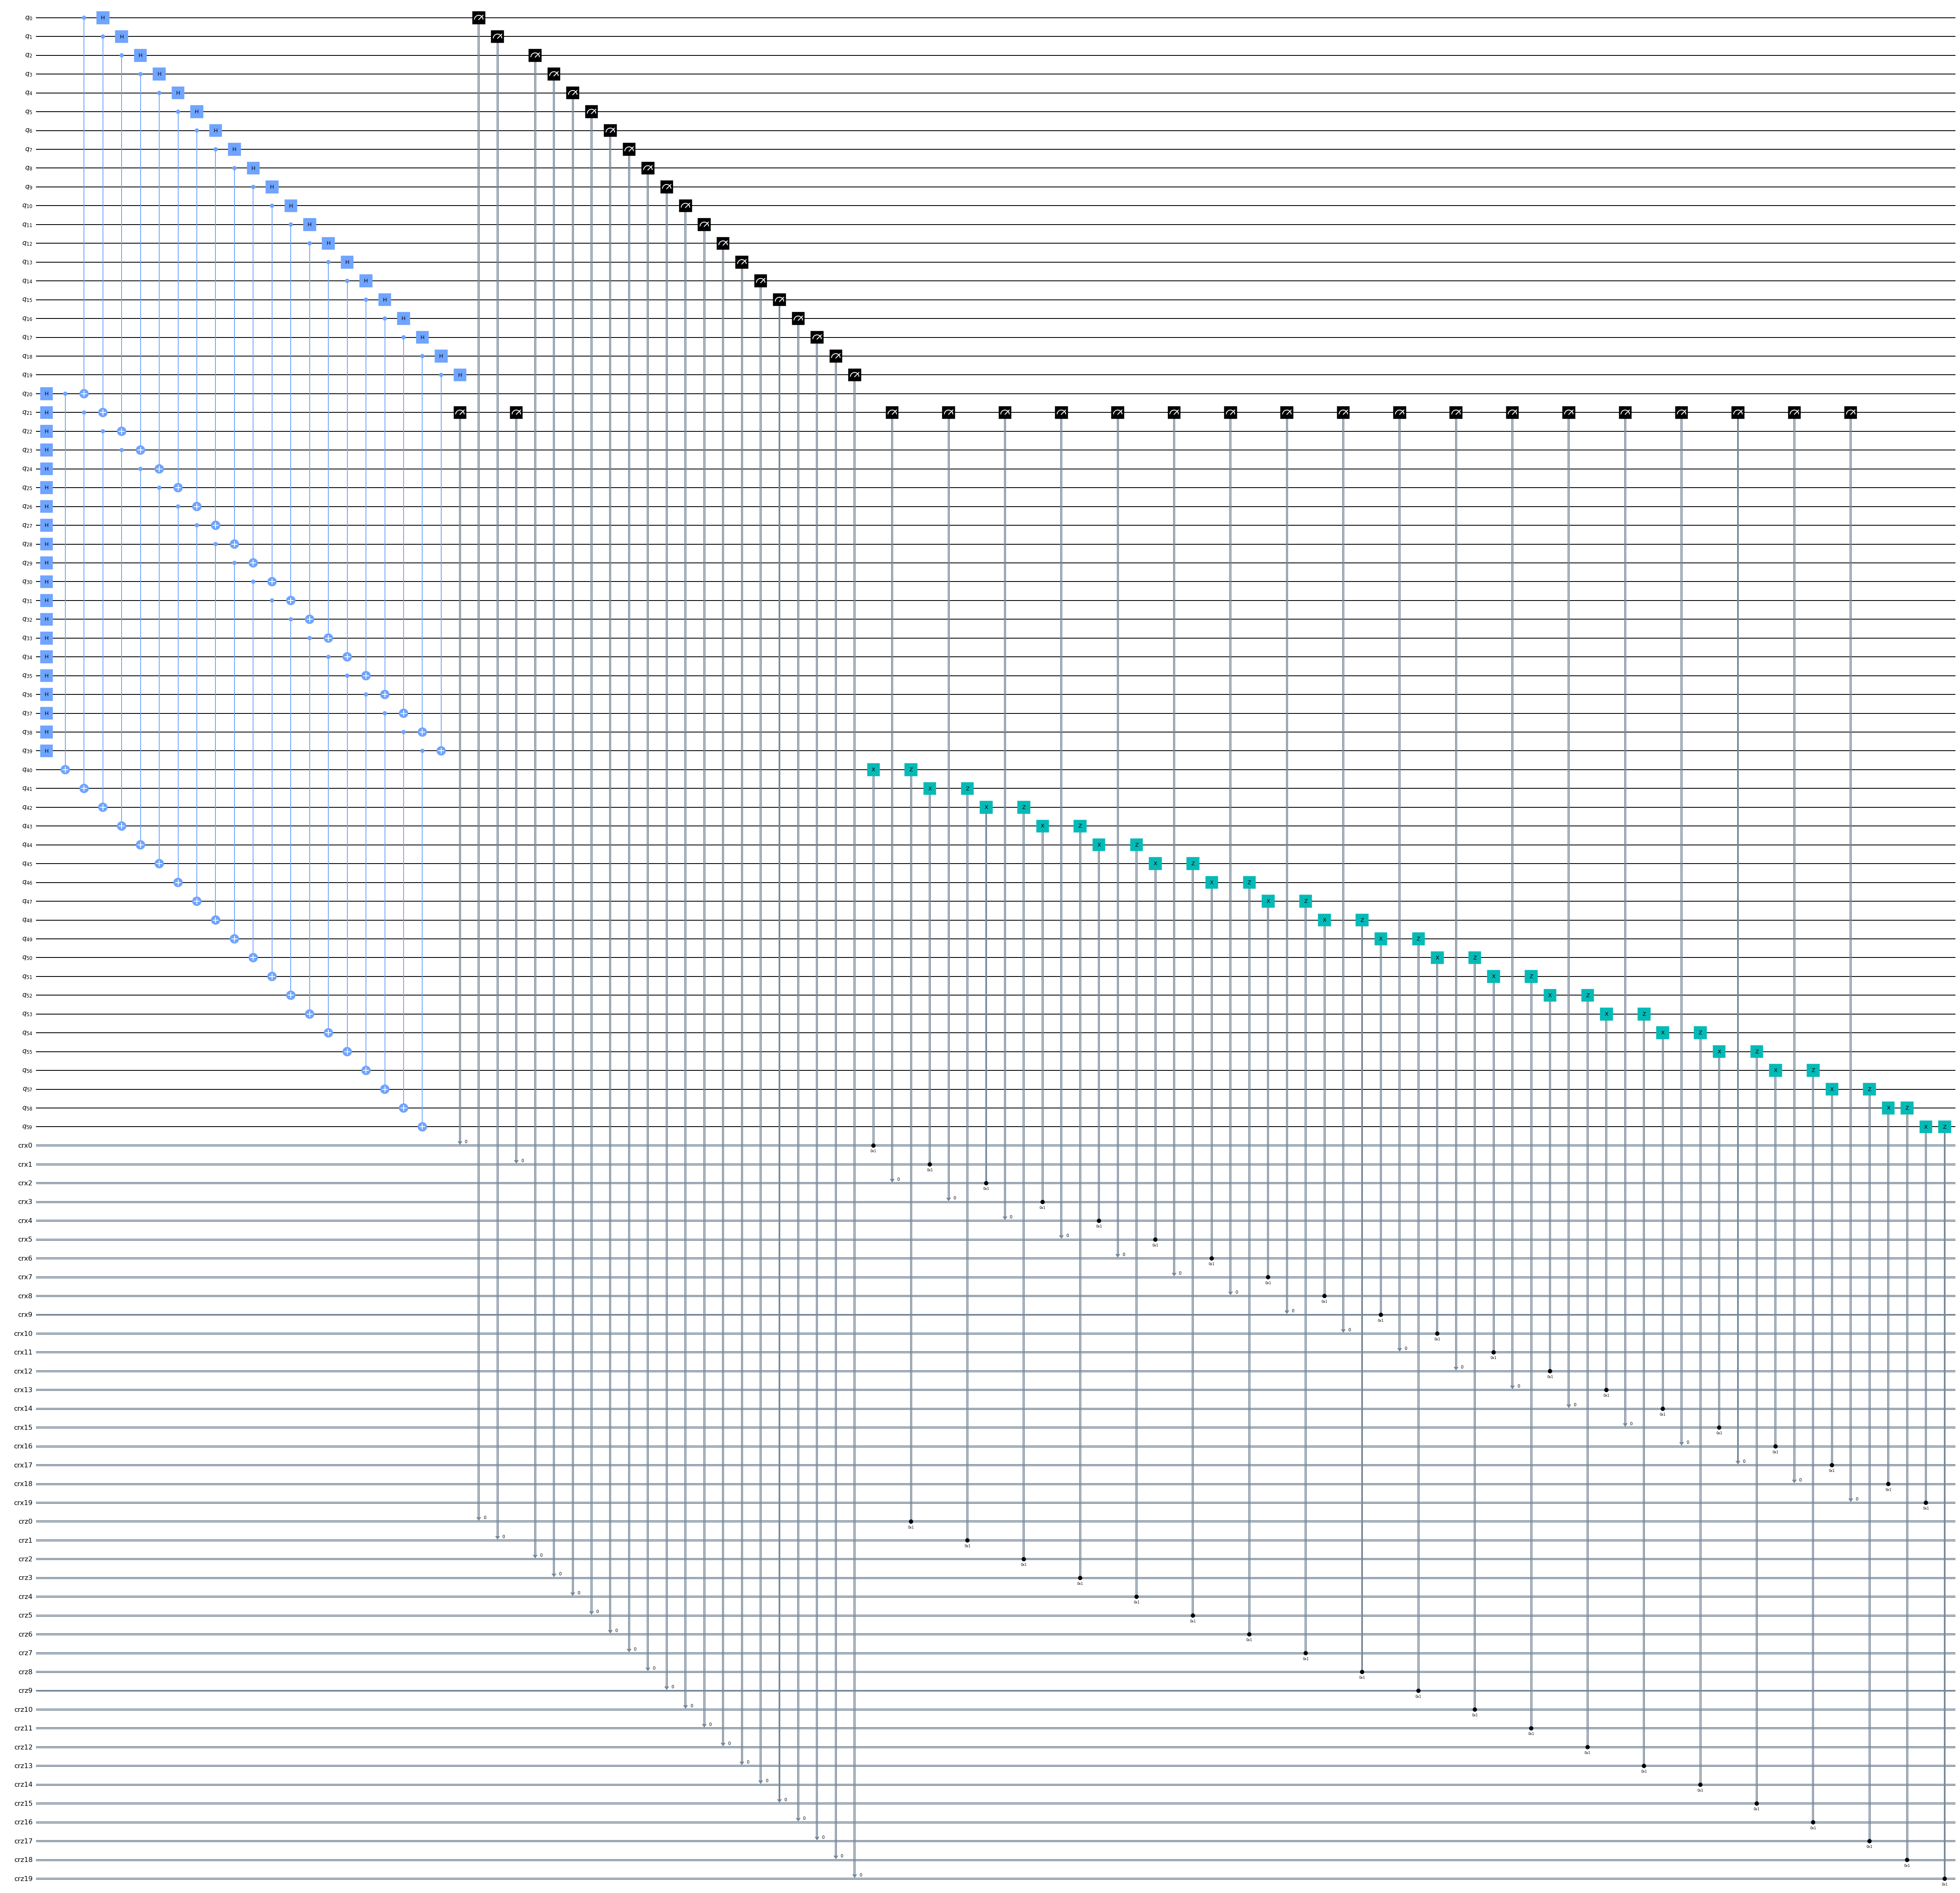

In [10]:
total = 20

nq = 3*total
qr = QuantumRegister(nq, name="q")
crz = [total]
crx = [total]
for i in range(total):
    crz[i] = ClassicalRegister(1, name="crz"+str(i))
    crx[i] = ClassicalRegister(1, name="crx"+str(i))
    crz.append(crz[i])
    crx.append(crx[i])
    
crx.pop()
crz.pop()

x = (crx[i] for i in range(total))
z = (crz[i] for i in range(total))

qc = QuantumCircuit(qr, *x,*z)
#qc = QuantumCircuit(qr, crz[0],crx[0],crz[1] ,crx[1])

for i in range(0,total):
    qc.h(i+total)
    qc.cx(i+total,2*total+i)

#qc.barrier()

for i in range(total):
    qc.cx(i,i+total)
    qc.h(i)
    
#qc.barrier()

for i in range(total):
    #qc.measure([qr[i],qr[total+1]],[crz[i],crx[i]])
    qc.measure(qr[i],crz[i])
    qc.measure(qr[total+1],crx[i])

#qc.barrier()

for i in range(total):
    qc.x(2*total+i).c_if(crx[i], 1) # Apply gates if the registers 
    qc.z(2*total+i).c_if(crz[i], 1) # are in the state '1'

#qc.x(2*total+i).c_if(crx[2], 1)
qc.draw('mpl',fold=-1)
#c.draw('mpl',scale=0.5,fold=-1)

# Real Quantum Computer

In [6]:
IBMQ.load_account()
IBMQ.providers() 

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='iqc-africa-21-7', group='q-challenge', project='ex1-reccjoXDTLllGpyL2')>]

In [9]:
provider = IBMQ.get_provider(hub='ibm-q')

<IPython.core.display.Latex object>

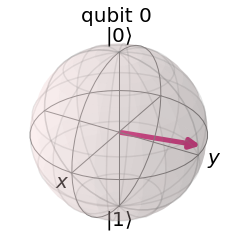

In [23]:
from qiskit_textbook.tools import random_state

# Create random 1-qubit state
psi = random_state(1)

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

In [24]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

In [27]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [29]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [30]:
from qiskit.extensions import Initialize
init_gate = Initialize(psi)
init_gate.label = "init"

In [32]:
inverse_init_gate = init_gate.gates_to_uncompute()

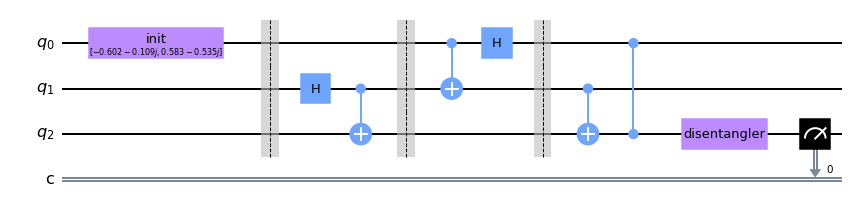

In [34]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw('mpl')

In [37]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
#backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   #not b.configuration().simulator and b.status().operational==True))
backend = provider.get_backend('ibmq_belem')    
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)
job_monitor(job)  # displays job status under cell

Job Status: job has successfully run


{'0': 910, '1': 114}


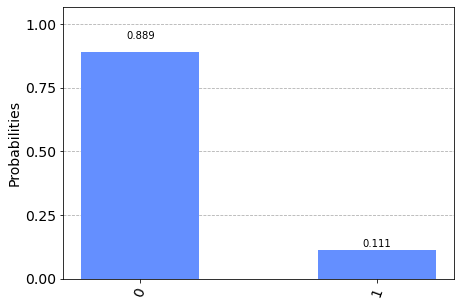

In [38]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)

In [52]:
print(f"The experimental Success rate : {exp_counts['0']/sum(exp_counts.values())*100:.2f}%")

The experimental Success rate : 88.87%


# Simulator

In [41]:
backend = Aer.get_backend('qasm_simulator')    
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)

{'0': 1024}


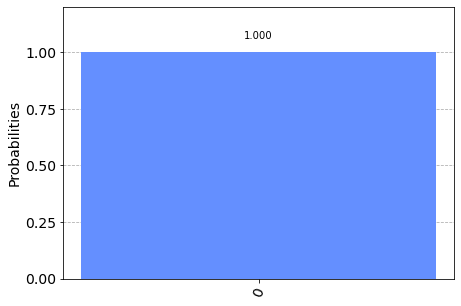

In [42]:
result = job.result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

In [53]:
print(f"The experimental Success rate : {counts['0']/sum(counts.values())*100:.2f}%")

The experimental Success rate : 100.00%


# Comparing

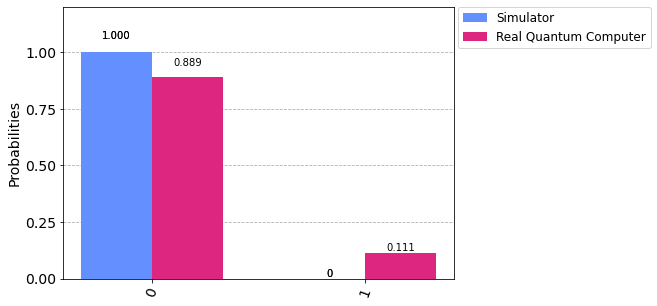

In [56]:
legend = ['Simulator','Real Quantum Computer']
plot_histogram([counts, exp_counts], legend=legend)